In [1]:
%load_ext autoreload
%autoreload 3

In [2]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(os.path.abspath(""))))

# Bootstrapping para intervalos de confianza y contraste de hipótesis con Python

> Bootstrapping como método no paramétrico para comparar estadísticos y crear intervalos de confianza con Python.


## Introducción

Los métodos estadísticos basados en muestreo repetido **(resampling)** se engloban dentro de la _estadística no paramétrica_, ya que no requieren de ninguna asunción sobre la distribución de las poblaciones estudiadas. Son, por lo tanto, una alternativa a los test paramétricos _(t-test, anova,…)_ cuando no se satisfacen sus condiciones o cuando se quiere hacer inferencia sobre un parámetro distinto a la media. A lo largo de este documento, se describe y aplica uno de los métodos de _resampling_ más utilizados: el _bootstrapping_.

Desde el punto de vista teórico, el escenario ideal para realizar inferencia sobre una población es disponer de infinitas (o una gran cantidad) de muestras de dicha población. Si para cada muestra se calcula el estadístico de interés, por ejemplo, la media, se obtiene lo que se conoce como distribución muestral. Esta distribución tiene dos características: su promedio tiende a converger con el valor real del parámetro poblacional, y su dispersión permite conocer el error esperado al estimar el estadístico con una muestra de un tamaño determinado.

En la práctica, no suele ser posible acceder a múltiples muestras. Si solo se dispone de una muestra, y esta es representativa de la población, cabe esperar que los valores en la muestra aparezcan aproximadamente con la misma frecuencia que en la población. El método de **bootstrapping (Bradley Efron, 1979))** se basa en generar nuevas pseudo-muestras, del mismo tamaño que la muestra original, mediante muestreo repetido _(sampling with replacement)_ de los datos disponibles.

Si la muestra original es representativa de la población, la distribución del estadístico calculada a partir de las pseudo-muestras (bootstrapping distribution) se aproxima a la distribución muestral que se obtendría si se pudiera acceder a la población para generar nuevas muestras.

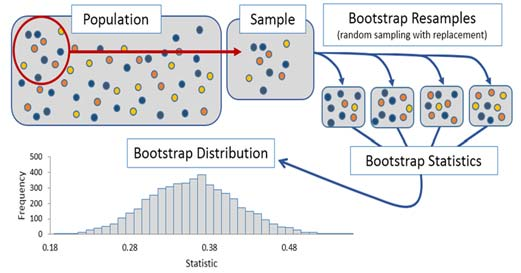

> Diagrama proceso de bootstrapping. Fuente: Frost, Oliver. (2018). Eine Webanwendung zur Planung und Auswertung von A/B-Tests auf Basis des Chi-Quadrat-Unabhängigkeitstests.


Así pues, bootstrapping es un proceso de simulación gracias al cual se puede aproximar la distribución muestral de un estadístico empleando únicamente una muestra inicial. Ahora bien, es importante destacar que información puede y no puede extraerse.

- Bootstrapping no proporciona una mejor estimación del estadístico que la obtenida con la muestra original.

- Bootstrapping simula el proceso de muestreo y con ello la variabilidad generada por este proceso. Gracias a esto, permite estimar la incertidumbre que se puede esperar de un estadístico calculado a partir de una muestra.


La estrategia de bootstrapping se puede emplear para resolver varios problemas:

- Calcular intervalos de confianza de un parámetro poblacional.

- Calcular la significancia estadística (p-value) de la diferencia entre poblaciones.

- Calcular intervalos de confianza para la diferencia entre poblaciones.

En cada uno, la hipótesis nula es distinta y, por lo tanto, la simulación de muestreo que tiene que realizarse. Esto significa que, aunque similares, el algoritmo debe adaptarse a cada caso de uso. En los siguientes apartados se muestran ejemplos de distintas aplicaciones.


## Intervalos de confianza de un parámetro poblacional
